In [1]:
import os
os.chdir('/home/megatron/work')

import megatron
import pandas as pd
import numpy as np

In [2]:
lahman_file = 'data/lahman/core/Batting.csv'
#lahman = pd.read_csv(lahman_file)
#lahman_data = megatron.data.full.PandasData(lahman)
lahman_generator = megatron.data.generators.CSVGenerator(lahman_file, 10000)

In [3]:
cols = ['G','AB','R','H','2B','3B','HR','RBI','SB',
        'CS','BB','SO','IBB','HBP','SH','SF','GIDP']
inputs = megatron.FeatureSet(cols)

fillna = megatron.layers.Impute({np.nan: 0}, name='fillna')
inputs = fillna(inputs)
inputs = megatron.layers.Cast(np.int)(inputs)

# helpers
def single_fn(h, d, t, hr):
    return h - d - t - hr
singles = megatron.layers.Lambda(single_fn, name='Singles')(inputs[['H','2B','3B','HR']])
hit_types = megatron.layers.Concatenate('hit_types')([singles] + inputs[['2B','3B','HR']])
TB = megatron.layers.Dot(W=np.array([1,2,3,4]), name='TB')(hit_types)

# basics
PA = megatron.layers.Add(name='PA')(inputs[['AB', 'BB', 'HBP', 'SH', 'SF']])
BBp = megatron.layers.Divide(name='BB%')([inputs['BB'], PA])
Kp = megatron.layers.Divide(name='K%')([inputs['SO'], PA])
def obp(h, bb, hbp, ab, sf):
    return megatron.helpers.safe_divide(h + bb + hbp, ab + bb + hbp + sf)
OBP = megatron.layers.Lambda(obp, name='OBP')(inputs[['H','BB','HBP','AB','SF']])
SLG = megatron.layers.Divide(name='SLG')([TB, inputs['AB']])
AVG = megatron.layers.Divide(name='AVG')(inputs[['H', 'AB']])
ISO = megatron.layers.Subtract(name='ISO')([SLG, AVG])
def babip(h, hr, ab, k, sf):
    return megatron.helpers.safe_divide(h - hr, ab - k - hr + sf)
BABIP = megatron.layers.Lambda(babip, name='BABIP')(inputs[['H','HR','AB','SO','SF']])

outputs = [PA, BBp, Kp, OBP, SLG, AVG, ISO, BABIP]
P = megatron.Pipeline(inputs, outputs)

P.fit_generator(lahman_generator)
#P.fit(lahman_data)

#out = P.transform(lahman_data)
out_generator = P.transform_generator(lahman_generator)

In [4]:
next(out_generator)

{'AVG': array([0.    , 0.    , 0.    , ..., 0.2322, 0.2507, 0.    ], dtype=float16),
 'BABIP': array([0.    , 0.    , 0.    , ..., 0.2507, 0.3547, 0.    ], dtype=float16),
 'BB%': array([0.     , 0.     , 0.     , ..., 0.1089 , 0.08966, 0.     ],
       dtype=float16),
 'ISO': array([0.    , 0.    , 0.    , ..., 0.1426, 0.2585, 0.    ], dtype=float16),
 'K%': array([0.    , 0.    , 0.    , ..., 0.1432, 0.368 , 0.    ], dtype=float16),
 'OBP': array([0.    , 0.    , 0.    , ..., 0.3179, 0.331 , 0.    ], dtype=float16),
 'PA': array([  0,   0,   0, ..., 496, 435,   0]),
 'SLG': array([0.    , 0.    , 0.    , ..., 0.3748, 0.5093, 0.    ], dtype=float16)}

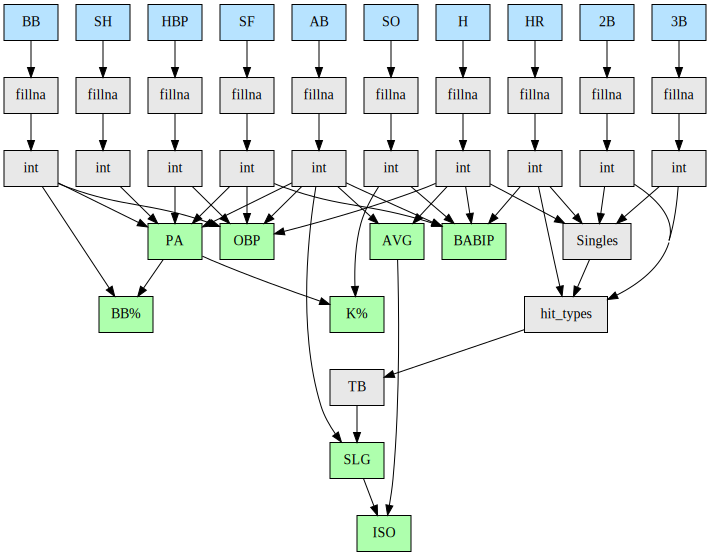

In [6]:
megatron.visuals.pipeline_imsave(P, 'img/sabermetrics.png')
megatron.visuals.pipeline_imshow(P)